# Exploratory Data Analysis

In the following, I analyze the dataset underlying the ML model for scheduling standby drivers.
<br>
I want to clarify which variables are interrelated, how they are distributed and thus find out which ones are suitable for the model as features.

#### Fragen?
* Are the data seasonal?
* What is the connection between how many standby drivers are needed?
* Frage 3

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
from datetime import datetime, date 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
import platform
print(platform.python_version())

3.8.5


In [5]:
import sys
print(sys.executable)

/Users/kata/opt/anaconda3/bin/python


### Load and inspect the data:

In [6]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv') #, index_col=0)
df['date'] = pd.to_datetime(df['date'])

Ideally, the data is already in chronological order and the time stamps are equidistant in time series. This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.
<br>
This column is provided in string format. Let's convert it to the datetime64[ns] data type.

[Quelle](https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting/notebook)

In [7]:
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01 00:00:00,73,8154.000000,1700,90,4.000000,0.000000
1,1,2016-04-02 00:00:00,64,8526.000000,1700,90,70.000000,0.000000
2,2,2016-04-03 00:00:00,68,8088.000000,1700,90,0.000000,0.000000
3,3,2016-04-04 00:00:00,71,7044.000000,1700,90,0.000000,0.000000
4,4,2016-04-05 00:00:00,63,7236.000000,1700,90,0.000000,0.000000


* **date:** entry date
* **n_sick:** number of drivers called sick on duty
* **calls:** number of emergency calls
* **n_duty:** number of drivers on duty available
* **n_sby:** number of standby resources available
* **sby_need:** number of standbys, which are activated on a given day
* **dafted:** number of additional drivers needed due to not enough standbys

In [8]:
# Check time intervals
df = df.sort_values(by='date')
df['Time_Interval'] = df.date - df.date.shift(1)

df[['date', 'Time_Interval']].head()

,date,Time_Interval
0,2016-04-01,NaT
1,2016-04-02,1 days
2,2016-04-03,1 days
3,2016-04-04,1 days
4,2016-04-05,1 days


The data should be in chronological order and the timestamps should be equidistant in time series. 
<br>
&rarr; IT IS

Let's look at numerical summaries:

In [9]:
df.describe(include = 'all')

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,Time_Interval
count,1152.000000,1152,1152.000000,1152.000000,1152.000000,1152.0,1152.000000,1152.000000,1151
unique,NaN,1152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2016-09-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2016-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,575.500000,NaN,68.808160,7919.531250,1820.572917,90.0,34.718750,16.335938,1 days 00:00:00
std,332.698061,NaN,14.293942,1290.063571,80.086953,0.0,79.694251,53.394089,0 days 00:00:00
min,0.000000,NaN,36.000000,4074.000000,1700.000000,90.0,0.000000,0.000000,1 days 00:00:00
25%,287.750000,NaN,58.000000,6978.000000,1800.000000,90.0,0.000000,0.000000,1 days 00:00:00


At least 4074 calls were received during the period, maximum 11.850. On average, 7919.53 calls were received.
<br>
On average, 34.7 drivers are needed on standby. However, since the maximum is 555, it is worth looking for outliers here.

Check for NaN-values:

In [10]:
df[df.isnull().any(axis=1)]

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,Time_Interval
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0,NaT


The following data types exist:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Unnamed: 0     1152 non-null   int64          
 1   date           1152 non-null   datetime64[ns] 
 2   n_sick         1152 non-null   int64          
 3   calls          1152 non-null   float64        
 4   n_duty         1152 non-null   int64          
 5   n_sby          1152 non-null   int64          
 6   sby_need       1152 non-null   float64        
 7   dafted         1152 non-null   float64        
 8   Time_Interval  1151 non-null   timedelta64[ns]
dtypes: datetime64[ns](1), float64(3), int64(4), timedelta64[ns](1)
memory usage: 90.0 KB


So sehen die Were in verschiedenen Spalten aus:

In [12]:
df.n_duty.unique()

array([1700, 1800, 1900])

This means, there is only three options of drivers on duty. The values increase over time.

In [13]:
df.n_sby.unique()

array([90])

There are always 90 drivers on standby.

In [14]:
def min_max(data):
    print(data.min())
    print(data.max())

In [15]:
min_max(df.date)

2016-04-01 00:00:00
2019-05-27 00:00:00


The data covers a period of three years, from April 1st 2016 to May 27th 2019.

Correlation matrix between all the features we are examining and our y-variable:

In [16]:
corr = df.corr()

print(corr)

            Unnamed: 0    n_sick     calls    n_duty  n_sby  sby_need  \
Unnamed: 0    1.000000  0.495959  0.385679  0.927437    NaN  0.137543   
n_sick        0.495959  1.000000  0.155371  0.459501    NaN  0.022321   
calls         0.385679  0.155371  1.000000  0.364135    NaN  0.677468   
n_duty        0.927437  0.459501  0.364135  1.000000    NaN  0.090654   
n_sby              NaN       NaN       NaN       NaN    NaN       NaN   
sby_need      0.137543  0.022321  0.677468  0.090654    NaN  1.000000   
dafted        0.131938  0.016800  0.557340  0.084955    NaN  0.945168   

              dafted  
Unnamed: 0  0.131938  
n_sick      0.016800  
calls       0.557340  
n_duty      0.084955  
n_sby            NaN  
sby_need    0.945168  
dafted      1.000000  


### Investigate graphically

Make pairplots to investigate data further and spot correlations:

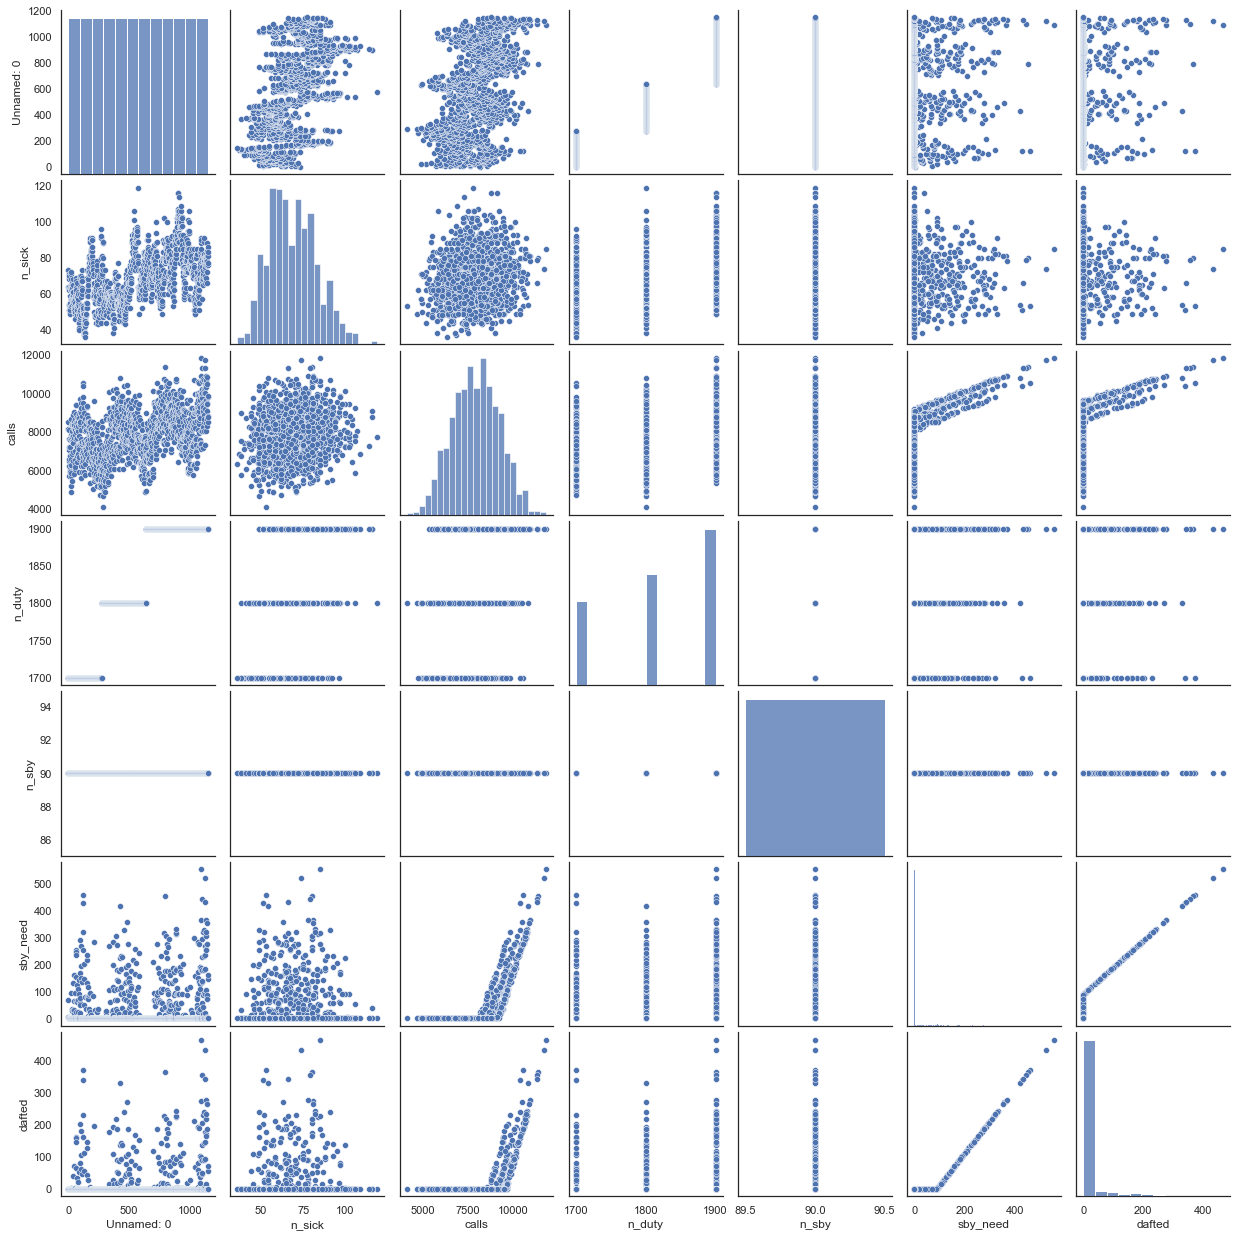

In [17]:
sns.set_theme(style="white")

sns.pairplot(df)

n_sick und calls sind saisonal, bei sby_need und calls sieht man, dass es erst ab 8000 calls Standby-Fahrer braucht.

The distribution of "sby_need" looks interesting, this is how the histogram looks in detail:

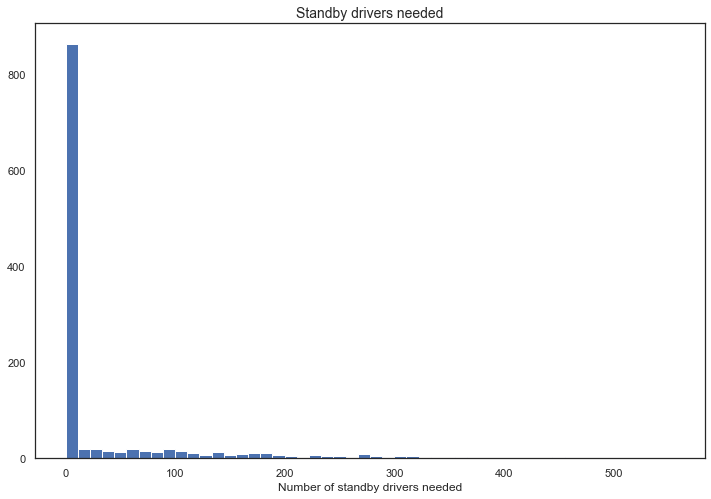

In [18]:
plt.figure(figsize=(12, 8))
plt.clf()
plt.hist(df.sby_need, bins=50)
plt.title('Standby drivers needed', fontsize=14)
plt.xlabel('Number of standby drivers needed')
plt.show()

In [19]:
new_df2 = df.groupby(['sby_need']).size()
print(new_df2)

sby_need
0.0      849
2.0        3
4.0        4
5.0        1
6.0        2
        ... 
445.0      1
454.0      1
461.0      1
523.0      1
555.0      1
Length: 185, dtype: int64


Standby drivers were not needed in nearly three-quarters of the cases. However, there are also individual cases in which several hundred were needed.
<br>
Another graphic will illustrate this.

<Figure size 432x288 with 0 Axes>

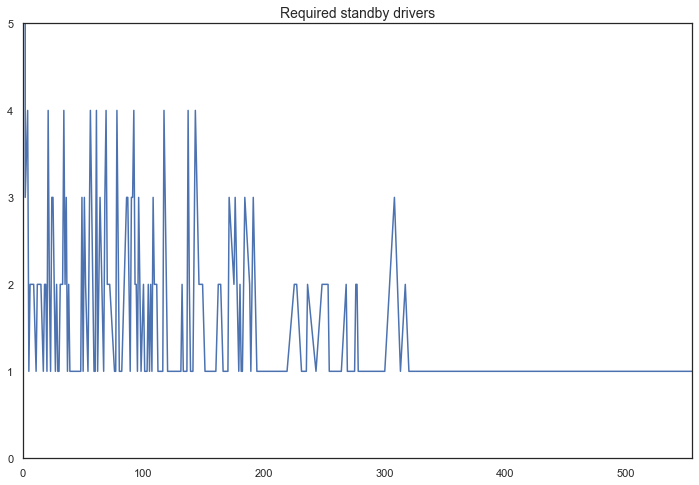

In [20]:
# needed???
plt.clf()
plt.figure(figsize=(12, 8))
plt.plot(new_df2)
plt.axis([0, 555, 0, 5])
plt.title('Required standby drivers', fontsize=14)
plt.show()

Most of the time no standby drivers were needed, otherwise between 2 and 5. It could become problematic that there are numerous individual cases where hundreds were needed.

Visualize data over the years:

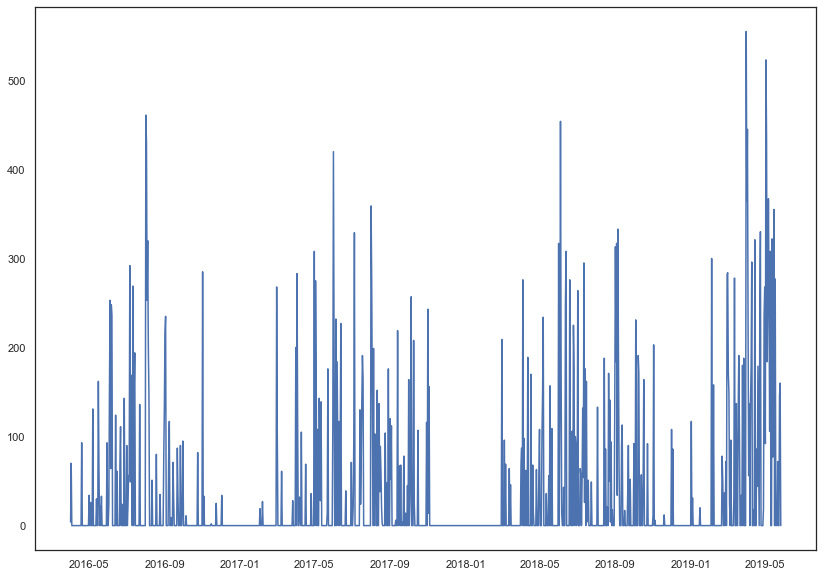

In [21]:
plt.figure(figsize=(14,10))
plt.plot(df.date, df.sby_need)
#plt.xticks([204, 650, 900], ['19.4.2016', '16.5.2016', '4.6.2016'])
plt.show()

### Further Correlations

We observe that the number of drivers increases over the years. Is there a correlation with the number of calls?

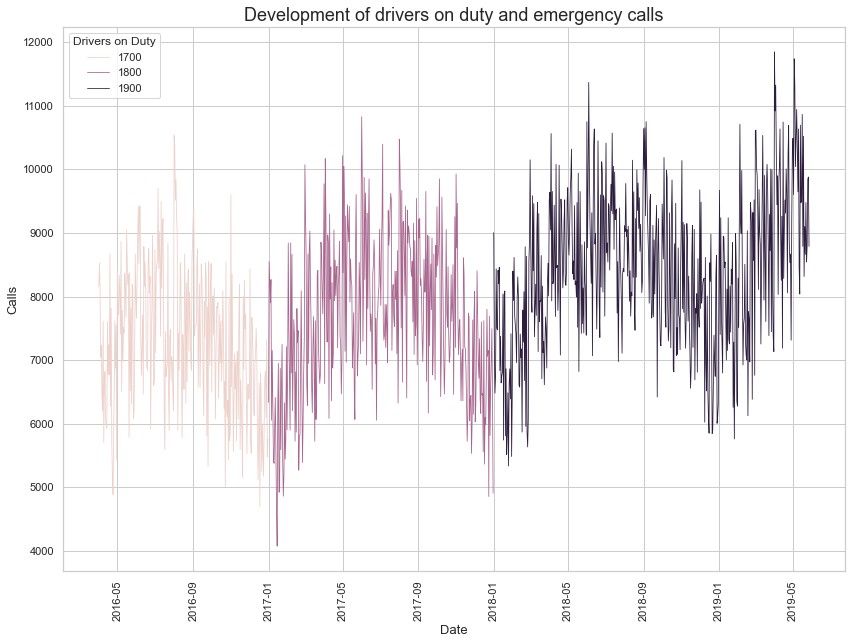

In [22]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.lineplot(x='date', y='calls', hue='n_duty', data=df, linewidth = 0.8)
#plt.xticks([0, 275, 640, 1151], ['01.04.2016', '01.01.2017', '01.01.2018', '27.05.2019'])

plt.xticks(rotation=90)
plt.legend(labels=["1700","1800", "1900"], title = "Drivers on Duty")
plt.xlabel('Date', fontsize=13)
plt.ylabel('Calls', fontsize=13)
plt.title('Development of drivers on duty and emergency calls', fontsize=18)

plt.savefig("dev_n_duty_calls.svg")
plt.show()

The graph shows that the number of drivers on duty increases with the number of calls.

In [23]:
print(pearsonr(df.calls, df.n_duty)[0])

0.36413536110780714


According to Pearson's correlation coefficient r, the two variables are slightly positively correlated with a value of 0.36.

What about the number of calls and the number of drivers on sick leave?

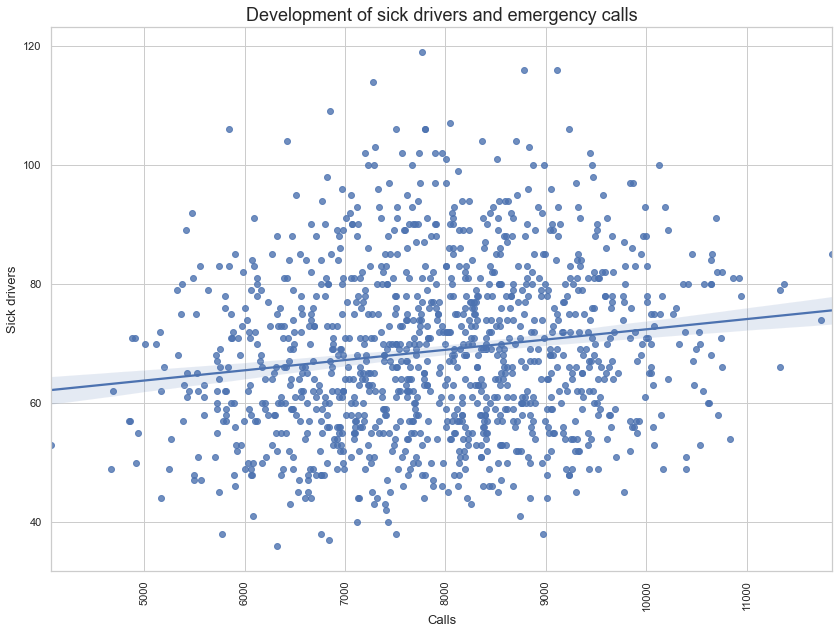

In [24]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.regplot(x='calls', y='n_sick', data=df)
plt.xticks(rotation=90)

plt.title('Development of sick drivers and emergency calls', fontsize=18)
plt.xlabel('Calls', fontsize=13)
plt.ylabel('Sick drivers', fontsize=13)

plt.show()

If the number of calls increases, the number of sick drivers slightly increases

In [25]:
print(pearsonr(df.calls, df.n_sick)[0])

0.15537086860280808


The variables are weakly positively correlated.

The pairplot above suggests a correlation between calls and drivers needed. Pearson's r confirms this:

In [26]:
print(pearsonr(df.calls, df.sby_need)[0])

0.677467517263761


The variables "n_sick" and "sby_need" are less related than thought:

In [27]:
print(pearsonr(df.n_sick, df.sby_need)[0])

0.022321406858650947


### check if data is stationary

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has
<br>
* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent


If a time series has a specific (stationary) behavior over a given time interval, then it can be assumed that the time series will behave the same at a later time.
<br>
Time series with trend and/or seasonality are not stationary. Trend indicates that the mean is not constant over time and seasonality indicates that the variance is not constant over time.

[Source](https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting/notebook)

Visual check:

<AxesSubplot:xlabel='date', ylabel='sby_need'>

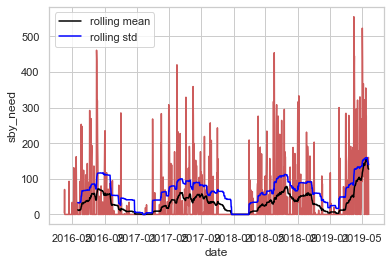

In [28]:
#sby_need
rolling_window = 52
sns.lineplot(x=df.date, y=df.sby_need, color='indianred')
sns.lineplot(x=df.date, y=df.sby_need.rolling(rolling_window).mean(), color='black', label='rolling mean')
sns.lineplot(x=df.date, y=df.sby_need.rolling(rolling_window).std(), color='blue', label='rolling std')


Mean and variance is not constant.
<br>
&rarr; doesn't seem to be stationary


<AxesSubplot:xlabel='date', ylabel='calls'>

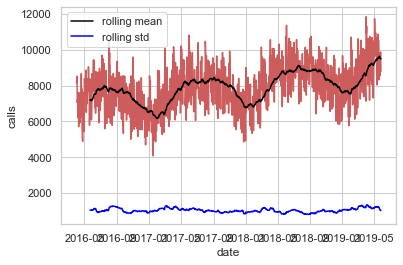

In [29]:
# calls
sns.lineplot(x=df.date, y=df.calls, color='indianred')
sns.lineplot(x=df.date, y=df.calls.rolling(rolling_window).mean(), color='black', label='rolling mean')
sns.lineplot(x=df.date, y=df.calls.rolling(rolling_window).std(), color='blue', label='rolling std')


Mean and variance is not constant.
<br>
&rarr; doesn't seem to be stationary


Summary statistics:

In [30]:
def mean_var(data):
    X = data.values
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))

check for standby drivers:

In [31]:
mean_var(df.sby_need)

mean1=29.512153, mean2=39.925347
variance1=4921.836658, variance2=7715.266996


check for calls:

In [32]:
mean_var(df.calls)

mean1=7563.270833, mean2=8275.791667
variance1=1442094.551649, variance2=1629701.164931


Mean and variance values for both are different and not in the same ball park.

Augmented Dickey-Fuller Test

In [33]:
from statsmodels.tsa.stattools import adfuller

In [34]:
#sby_need
result = adfuller(df.sby_need.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']

In [35]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=df.date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

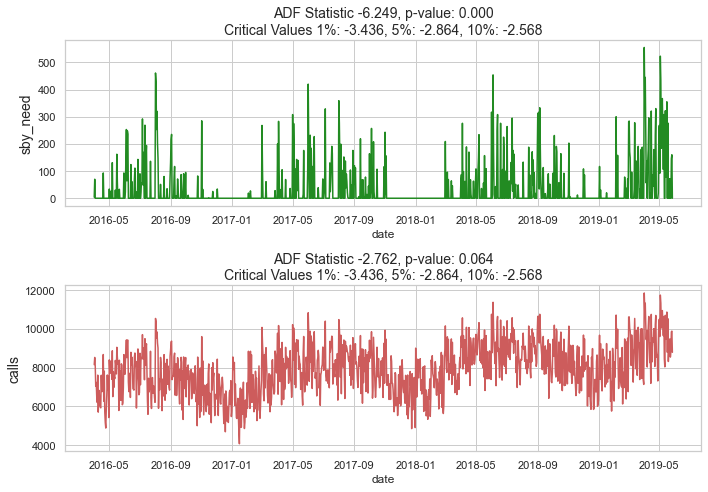

In [36]:

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
visualize_adfuller_results(df.sby_need.values, 'sby_need', ax[0])
visualize_adfuller_results(df.calls.values, 'calls', ax[1])

plt.tight_layout()
plt.show()

sby_need:
<br>
**p-value <= significance level (0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
<br>
(**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.)

calls:
<br>
**p-value > significance level**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. 
<br>
(**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.)

&rarr; calls not stationary

Running the test prints the test statistic value of -6. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).
<br>
As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -6 is less than the value of -3.436 at 1%.
<br>
This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).
<br>
We can also look at the p-value, which is 0. This means we can easily reject the null and consider the distribution as stationary.
<br>
Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.
<br>
<br>
&rarr; the data is  stationary ([Tutorial](https://machinelearningmastery.com/time-series-data-stationary-python/)
)

### KPSS test for stationarity

<br>
KPSS test is a statistical test to check for stationarity of a series around a deterministic trend. Like ADF test, the KPSS test is also commonly used to analyse the stationarity of a series. However, it has couple of key differences compared to the ADF test in function and in practical usage. Therefore, is not safe to just use them interchangeably. We’ll discuss this detail with simplified examples.

[Resource](https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/)

A key difference from ADF test is the null hypothesis of the KPSS test is that the series is stationary.
<br>
So practically, the interpretaion of p-value is just the opposite to each other.

In [37]:
from statsmodels.tsa.stattools import kpss

In [38]:
# eher den nehmen!!!!!!!!!

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


print('CALLS')
kpss_test(df.calls)
print('SBY NEED')
kpss_test(df.sby_need)

CALLS
Results of KPSS Test:
Test Statistic            2.28927
p-value                   0.01000
Lags Used                18.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64
SBY NEED
Results of KPSS Test:
Test Statistic            0.705928
p-value                   0.013007
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/kata/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, both series are non-stationary as per the KPSS test.

In [39]:

# with or without regression?
# zweite quelle: https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/

In [40]:
def kpss_test2(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

print('CALLS')
kpss_test2(df.calls, regression="c")
print('SBY NEED')
kpss_test2(df.sby_need, regression="c")

CALLS
KPSS Statistic: 1.889905310003391
p-value: 0.01
num lags: 23
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
SBY NEED
KPSS Statistic: 0.5760963913177181
p-value: 0.024809418971116538
num lags: 23
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/Users/kata/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


FINAL RESULT: Calls non stationary
<br>
KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

[Difference between KPSS and ADF](https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/)

# stationary calls???

In [41]:
# make calls stationary???

## Transformation of non stationary calls

In [42]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['calls_log'] = np.log(abs(df.calls))


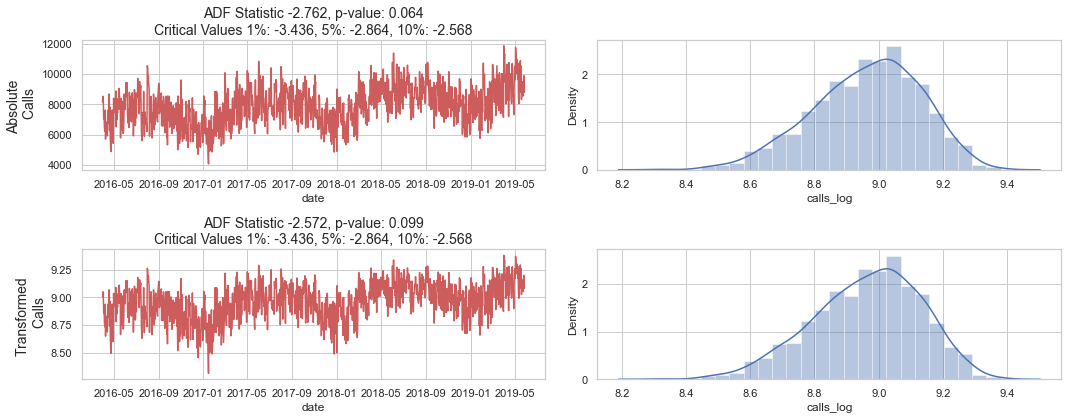

In [43]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
visualize_adfuller_results(abs(df.calls), 'Absolute \n Calls', ax[0, 0])

sns.distplot(df.calls_log, ax=ax[0, 1])
visualize_adfuller_results(df.calls_log, 'Transformed \n Calls', ax[1, 0])

sns.distplot(df.calls_log, ax=ax[1, 1])

plt.tight_layout()
plt.show()

In [44]:
#hä?? was hat das gebracht?

In [45]:
# another way: differencing



In [46]:
# First Order Differencing
calls_diff = np.diff(df.calls)
df['calls_diff_1'] = np.append([0], calls_diff)

In [47]:
df.head()

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,Time_Interval,calls_log,calls_diff_1
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0,NaT,9.006264,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0,1 days,9.050876,372.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0,1 days,8.998137,-438.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0,1 days,8.859931,-1044.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0,1 days,8.886824,192.0


In [48]:
# The differencing can be reverted if the the first value before differencing is known. 
# In this case, we can accumulate all values with the function .cumsum() and add the first value of the original time series.


df.calls.equals(df.calls_diff_1.cumsum() + df.calls.iloc[0])


True

In [49]:
print('p-value: ' + str(adfuller(df.calls_diff_1.dropna())[1]))

p-value: 1.8767915532070636e-20


In [50]:
# EDA fängt eig erst hier an

## seasonality

Check seasonality of the Standby drivers needed:

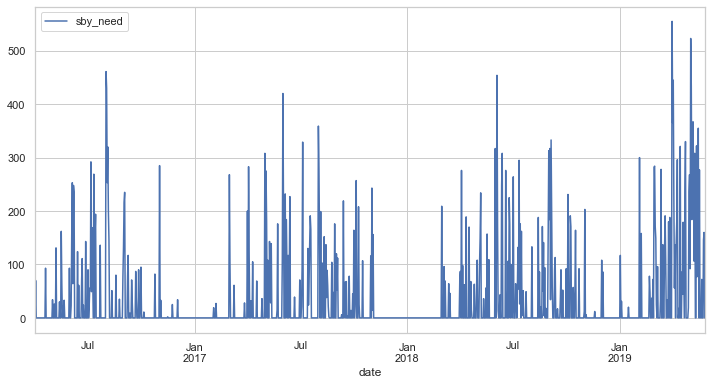

In [51]:
ax = df.plot(x='date', y='sby_need', figsize=(12,6))
#plt.xticks([275, 640, 1005], ['01.01.2017', '01.01.2018', '01.01.2019'])
xcoords = [275, 640, 1005]
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

seasonality of calls:

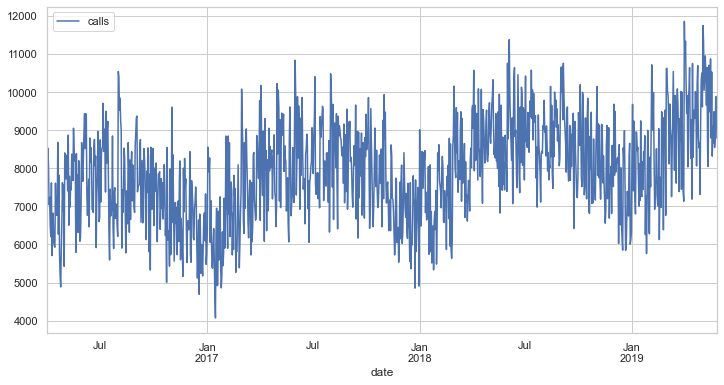

In [52]:
ax = df.plot(x='date', y='calls', figsize=(12,6))
#plt.xticks([275, 640, 1005], ['01.01.2017', '01.01.2018', '01.01.2019'])
xcoords = [275, 640, 1005]
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

seasonal decomposition:

In [53]:
# split variable into components to see seasonal variation

def decompose(data):
    res = sm.tsa.seasonal_decompose(data, period=365, model='additive')
    fig = res.plot()
    fig.set_size_inches(14,7)
    plt.show()

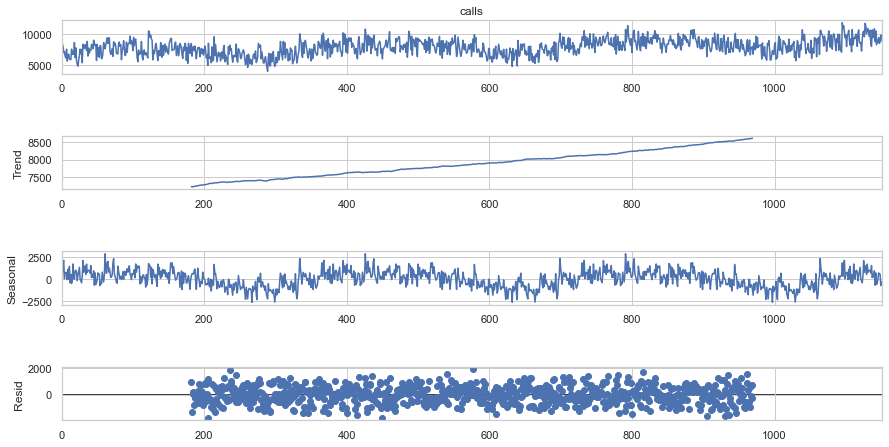

In [54]:
# decompose calls
decompose(df.calls)

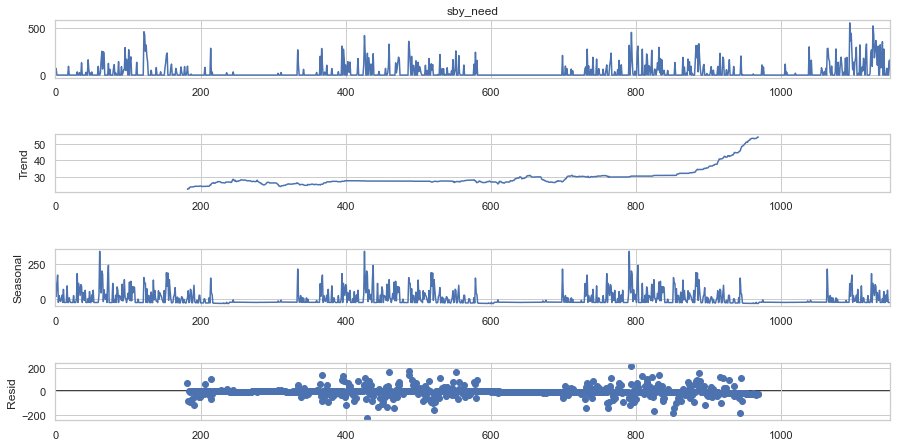

In [55]:
decompose(df.sby_need)

In [56]:
# correlation matrix

# calculate autocorrelation

with this [resource](https://www.alpharithms.com/autocorrelation-time-series-python-432909/)

In [57]:
from statsmodels.graphics.tsaplots import plot_acf

In [58]:
# perform autocorrelation & visualization
def autocorr(data):
    res = sm.graphics.tsa.plot_acf(x=data, lags=100)
    res.set_size_inches(14,7)
    plt.show()

#The red shaded region is the confidence interval with a default value of α = 0.05. 
#Anything within this range represents a value that has no significant correlation with the most recent value.

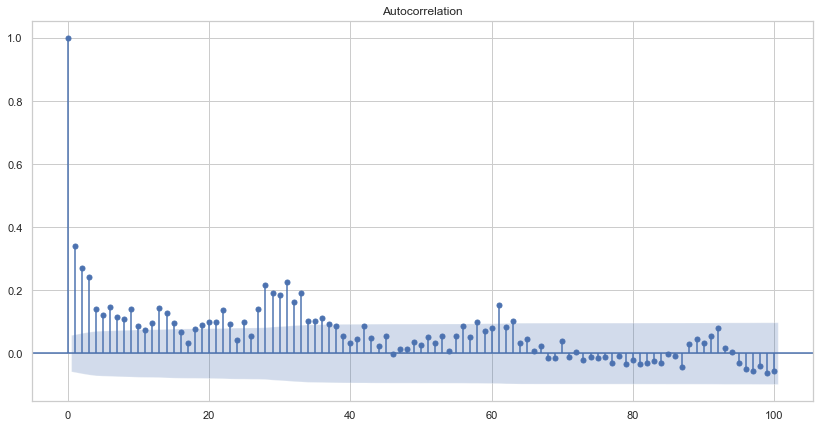

In [59]:
autocorr(df.sby_need)

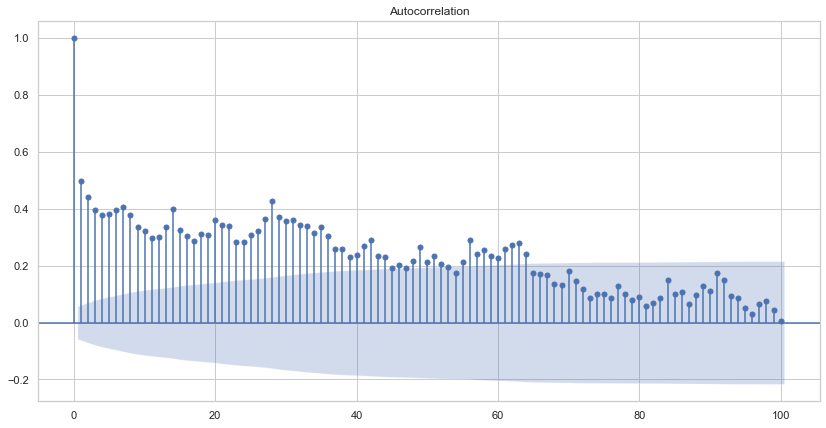

In [60]:
autocorr(df.calls)

In [61]:
# get lags over confidence intervall
from statsmodels.tsa.stattools import acf

def get_lags(data):
    a, ci = acf(x=data, nlags=100, alpha=0.05, fft=True)
    centered_ci = ci - a[:,None]
    outside = np.abs(a) >= centered_ci[:,1]
    inside = ~outside

    return outside


In [62]:
lags_sby = get_lags(df.sby_need)


In [63]:
lags_calls = get_lags(df.calls)


In [64]:
def lags_count(array):
    a = sum(x==True for x in array)
    return a

In [65]:
lags_count(lags_sby)

35

In [66]:
lags_count(lags_calls)

63

In [67]:
# another way
# resource: https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting/notebook

from pandas.plotting import autocorrelation_plot

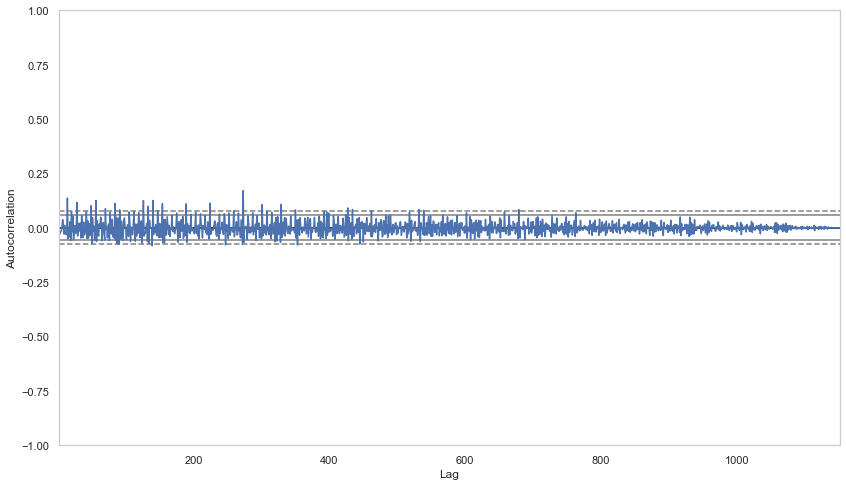

In [68]:
plt.figure(figsize=(14,8))
autocorrelation_plot(df.calls_diff_1)
plt.show()

In [69]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

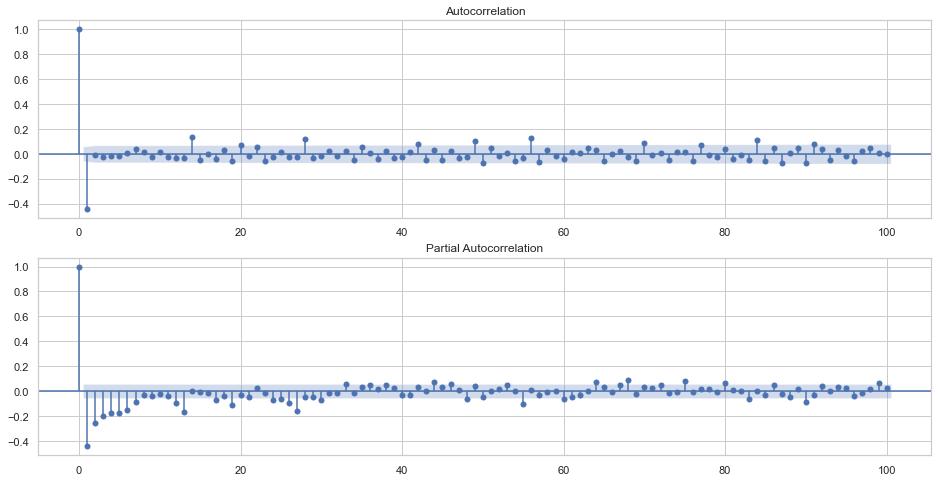

In [70]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df.calls_diff_1,lags=100, ax=ax[0])
plot_pacf(df.calls_diff_1,lags=100, ax=ax[1])
plt.show()

# cross validation (WAS IS DAS)

In [71]:
from sklearn.model_selection import TimeSeriesSplit


In [72]:
N_SPLITS = 3

X = df.date
y = df.calls

folds = TimeSeriesSplit(n_splits=N_SPLITS)

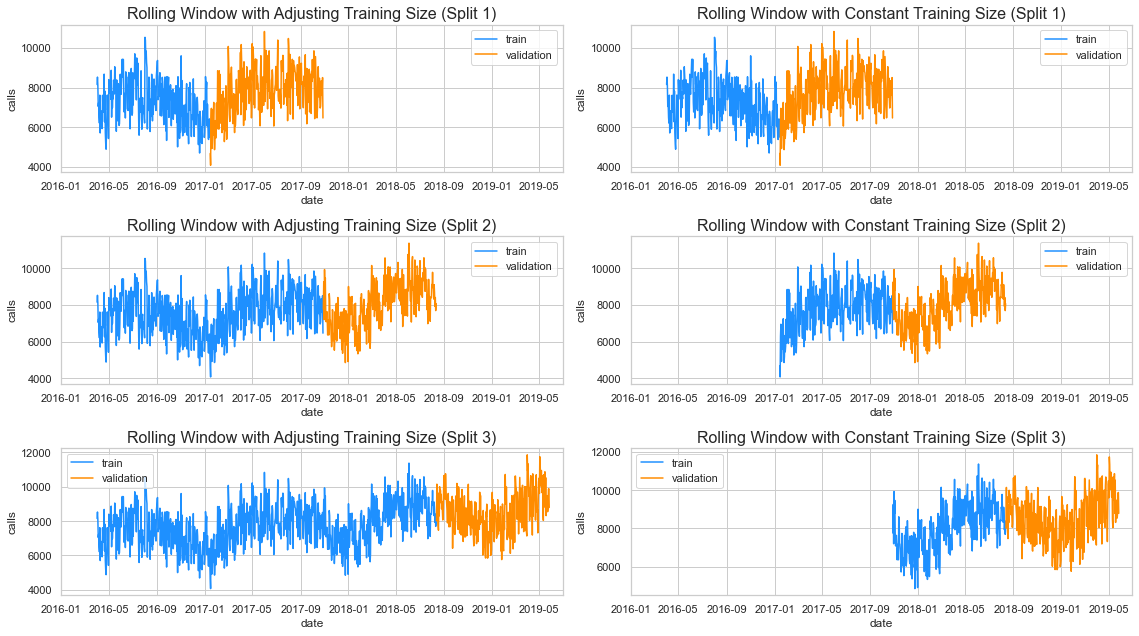

In [73]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2016, 1, 1), date(2019, 6, 30)])
    ax[i, 1].set_xlim([date(2016, 1, 1), date(2019, 6, 30)])
plt.tight_layout()
plt.show()